<a href="https://colab.research.google.com/github/pirisc/portfolio/blob/main/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0. Computer vision libraries

In [ ]:
# Import PyTorch
import torch
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

# Import matplotlib
import matplotlib.pyplot as plt

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Getting a dataset

We're going to use the MNIST dataset that contains thousands of

In [ ]:
# Setup training data
train_data = datasets.MNIST(
    root = "data",
    train = True,
    download = True,
    transform = ToTensor(),
    target_transform = None
)

# Set upt testing data
test_data = datasets.MNIST(
    root = "data",
    train = False,
    transform = ToTensor()
)

In [ ]:
# See first training sample
image, label = train_data[0]
image, label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [ ]:
# What's the shape of our images?
print(f"Image size: {image.shape} -> [color_channels, height, width]")

Image size: torch.Size([1, 28, 28]) -> [color_channels, height, width]


In [ ]:
# How many examples do we have?
len(train_data.data), len(train_data.targets), len(test_data.data), len(test_data.targets)

(60000, 60000, 10000, 10000)

In [ ]:
# See classes
class_names = train_data.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

### 1.1 Visualing our data

Image shape: torch.Size([1, 28, 28])


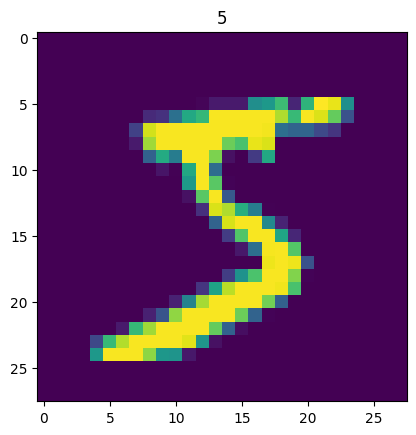

In [ ]:
import matplotlib.pyplot as plt
image, label = train_data[0]
print(f"Image shape: {image.shape}")
plt.imshow(image.squeeze())
plt.title(label);

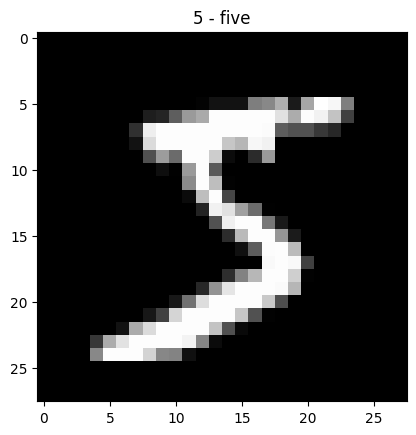

In [ ]:
# Show the image into grayscale
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label]);

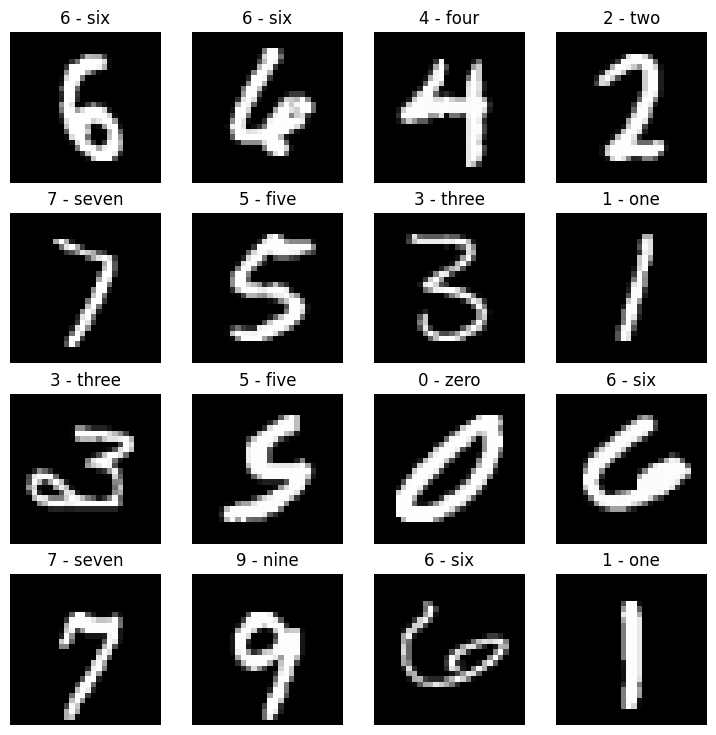

In [ ]:
# Plot more images
fig = plt.figure(figsize=(9,9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(class_names[label])
  plt.axis(False);

## 2. Prepare DataLoader

In [ ]:
from torch.utils.data import DataLoader

# Set up batch size
BATCH_SIZE = 32

# Turn datasets into iterables
train_dataloader = DataLoader(train_data,
                              batch_size=BATCH_SIZE,
                              shuffle= True)

test_dataloader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             shuffle= False)

# Print some info
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32


## Model 0: Baseline model

In [ ]:
# Define the model
from torch import nn
class MNISTModelV0(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape, out_features=hidden_units),
        nn.Linear(in_features=hidden_units, out_features=output_shape)
    )

  def forward(self, x):
    return self.layer_stack(x)

We have the following parameters:
* `input_shape = 784` (28 pixels height x 28 pixels width = 784)
* `hidden_units = 128` (this can be whatever number you want)
* `output_shape = len(class_names)`

In [ ]:
# Need to setup model with the parameters
model_0 = MNISTModelV0(input_shape=784,
                       hidden_units=128,
                       output_shape = len(class_names)).to(device)
model_0

MNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)

### 3.1 Set up loss, optimizer and evaluation metrics

In [ ]:
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

### 3.2. Make predictions for the baseline model

In [ ]:
from going_modular.going_modular import engine

set_seeds()

# Calculate results
model_0_results = engine.train(model= model_0,
                               train_dataloader = train_dataloader,
                               test_dataloader = test_dataloader,
                               optimizer = optimizer,
                               loss_fn = loss_fn,
                               epochs = 5,
                               device = device)




  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.3644 | train_acc: 0.8983 | test_loss: 0.3078 | test_acc: 0.9088
Epoch: 2 | train_loss: 0.2961 | train_acc: 0.9165 | test_loss: 0.2900 | test_acc: 0.9191
Epoch: 3 | train_loss: 0.2845 | train_acc: 0.9213 | test_loss: 0.2744 | test_acc: 0.9253
Epoch: 4 | train_loss: 0.2803 | train_acc: 0.9211 | test_loss: 0.2848 | test_acc: 0.9220
Epoch: 5 | train_loss: 0.2764 | train_acc: 0.9234 | test_loss: 0.2840 | test_acc: 0.9228


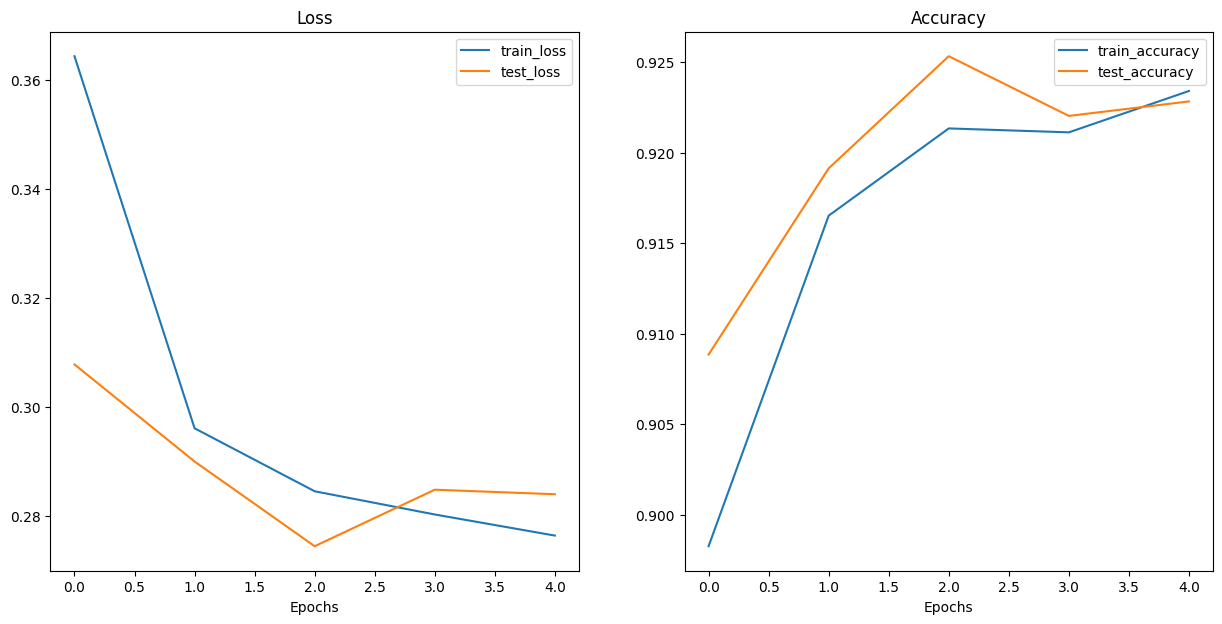

In [ ]:
# Plot loss curves
plot_loss_curves(model_0_results)

## Model 1: Building a Convolutional Neural Network (CNN)

In [ ]:
# Create a convolutional neural network
class MNISTModelV1(nn.Module):
    """
    Model architecture copying TinyVGG from:
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # It's because each layer of our network compresses and changes the shape of our input data.
            nn.Linear(in_features=hidden_units*7*7,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x


In [ ]:
set_seeds()
model_1 = MNISTModelV1(input_shape=1,
    hidden_units=10,
    output_shape=len(class_names)).to(device)
model_1

MNISTModelV1(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [ ]:
# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(),
                             lr=0.1)

In [ ]:
# Train the model
from going_modular.going_modular import engine

# Calculate results
model_1_results = engine.train(model= model_1,
                               train_dataloader = train_dataloader,
                               test_dataloader = test_dataloader,
                               optimizer = optimizer,
                               loss_fn = loss_fn,
                               epochs = 5,
                               device = device)



  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2685 | train_acc: 0.9123 | test_loss: 0.0777 | test_acc: 0.9745
Epoch: 2 | train_loss: 0.0682 | train_acc: 0.9790 | test_loss: 0.0427 | test_acc: 0.9871
Epoch: 3 | train_loss: 0.0536 | train_acc: 0.9839 | test_loss: 0.0422 | test_acc: 0.9865
Epoch: 4 | train_loss: 0.0451 | train_acc: 0.9852 | test_loss: 0.0406 | test_acc: 0.9855
Epoch: 5 | train_loss: 0.0399 | train_acc: 0.9869 | test_loss: 0.0361 | test_acc: 0.9880


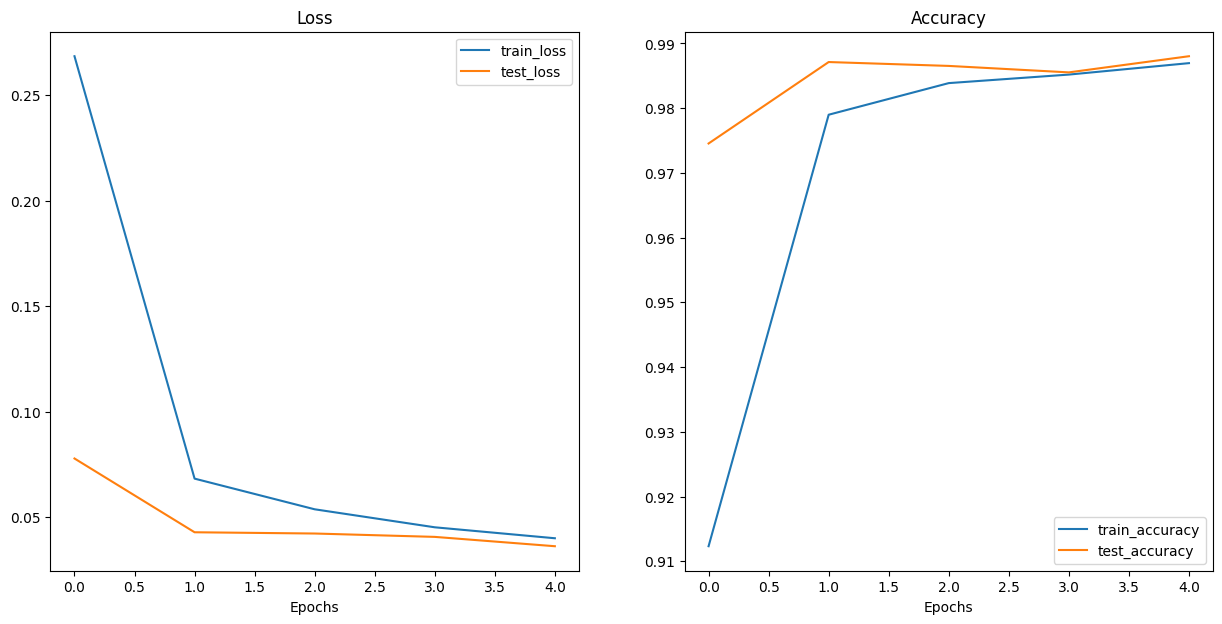

In [ ]:
# Plot loss curves
plot_loss_curves(model_1_results)

## Trying to improve our model up to 99% accuracy

In [ ]:
# Create a convolutional neural network
class MNISTModelV2(nn.Module):
    """
    Model architecture copying TinyVGG from
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2), # default stride value is same as kernel_size
            nn.Dropout(p=0.25)
            )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(p=0.25)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our input data.
            nn.Linear(in_features = hidden_units*7*7,
                      out_features = 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x


In [ ]:
model_2 = MNISTModelV2(input_shape=1,
                       hidden_units = 10,
                       output_shape = len(class_names)).to(device)
model_2

MNISTModelV2(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (

In [ ]:
# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr = 0.001)

In [ ]:
# Train the model
from going_modular.going_modular import engine

# Calculate results
model_2_results = engine.train(model= model_2,
                               train_dataloader = train_dataloader,
                               test_dataloader = test_dataloader,
                               optimizer = optimizer,
                               loss_fn = loss_fn,
                               epochs = 5,
                               device = device)


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2312 | train_acc: 0.9281 | test_loss: 0.0546 | test_acc: 0.9811
Epoch: 2 | train_loss: 0.0991 | train_acc: 0.9692 | test_loss: 0.0307 | test_acc: 0.9895
Epoch: 3 | train_loss: 0.0764 | train_acc: 0.9765 | test_loss: 0.0336 | test_acc: 0.9885
Epoch: 4 | train_loss: 0.0699 | train_acc: 0.9792 | test_loss: 0.0288 | test_acc: 0.9909
Epoch: 5 | train_loss: 0.0633 | train_acc: 0.9806 | test_loss: 0.0258 | test_acc: 0.9910


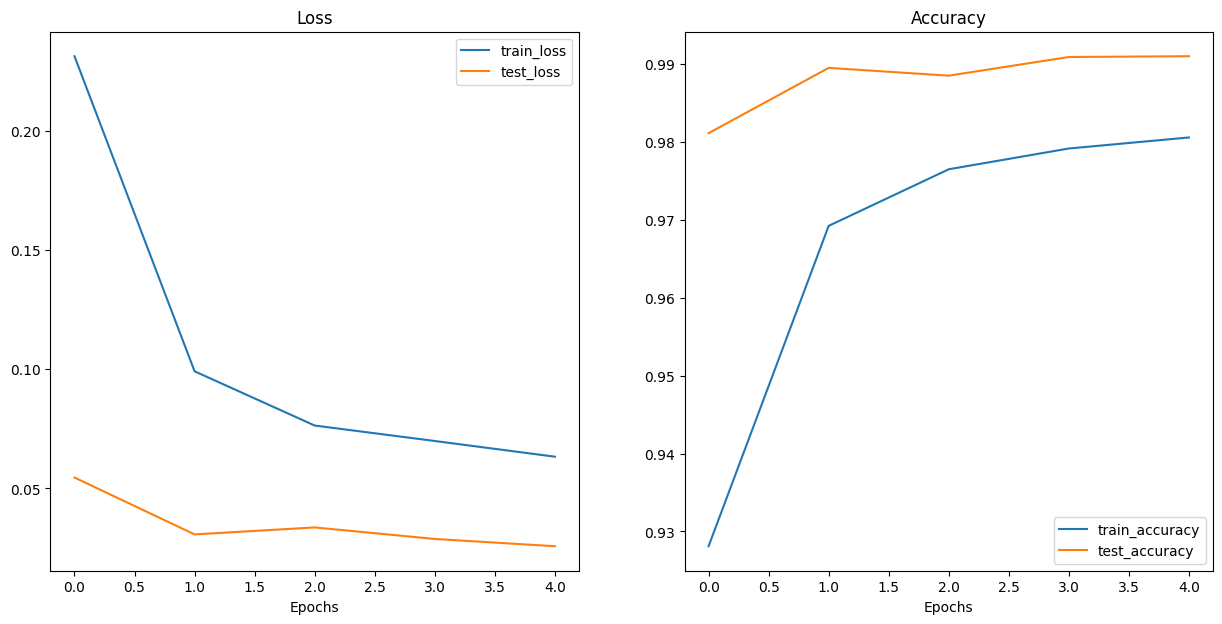

In [ ]:
# Plot loss curves
plot_loss_curves(model_2_results)

## Make predictions

In [ ]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 1, so can perform on dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())

    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

In [ ]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")

Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 2 (2 - two)


In [ ]:
# Make predictions on test samples with model 2
pred_probs= make_predictions(model=model_2,
                             data=test_samples)

# View first two prediction probabilities list
pred_probs[:2]

tensor([[5.6287e-09, 1.6907e-07, 1.0000e+00, 1.1259e-07, 1.8487e-13, 3.9224e-13,
         1.1451e-12, 1.7187e-06, 3.1462e-07, 2.1694e-11],
        [1.5233e-07, 9.9759e-01, 1.0725e-05, 1.1133e-06, 3.3791e-04, 9.7501e-06,
         6.6648e-05, 2.4291e-05, 1.3696e-03, 5.8868e-04]])

In [ ]:
# Turn the prediction probabilities into prediction labels by taking the argmax()
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([2, 1, 2, 4, 6, 6, 4, 9, 1])

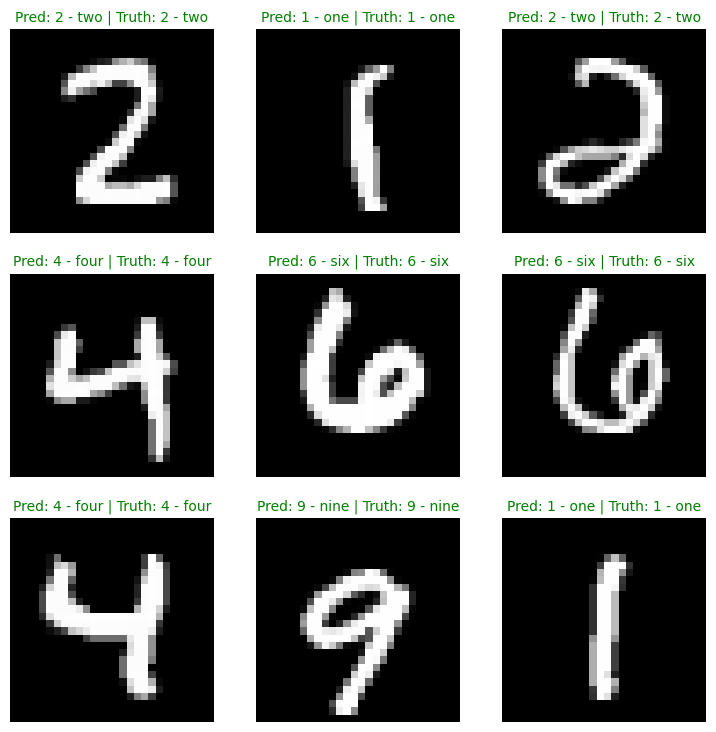

In [ ]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = class_names[pred_classes[i]]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = class_names[test_labels[i]]

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);

## Make a confusion matrix

In [ ]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
model_2.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model_2(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/313 [00:00<?, ?it/s]

In [ ]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 129.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 108.7 MB/s eta 0:00:00
mlxtend version: 0.23.4


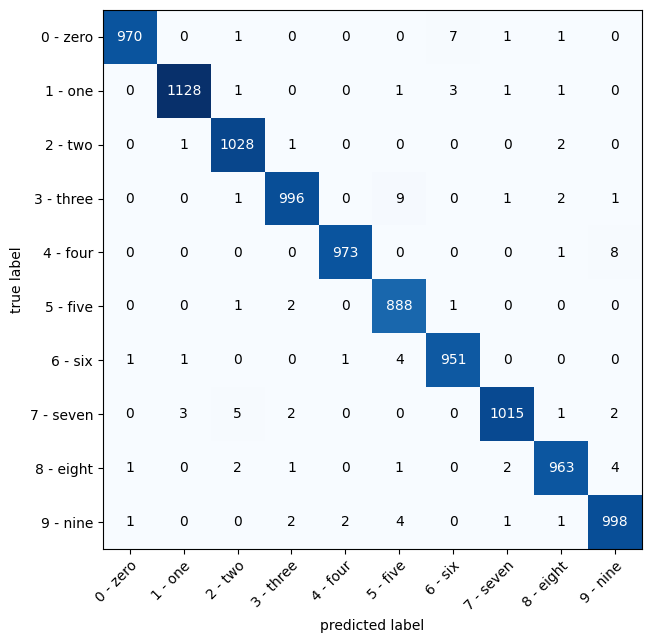

In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);

## 6 Trying a model with transfer learning

Even if most pretrained models expect 3 channels (RBG) our dataset only has 1(gray) and also the resolution for our dataset is 28x28.

We need to adjust this inputs a little to adapt them to our needs.

In [ ]:
from torchvision import transforms

# Get pretrained weights and transforms
weights = torchvision.models.ResNet18_Weights.DEFAULT

auto_transform = torchvision.transforms.Compose([
    transforms.Grayscale(num_output_channels = 3),
    weights.transforms()
])

In [ ]:
# Load the data with the correspondent transforms
train_dataset = datasets.MNIST(root="data", train=True, download=True, transform=auto_transform)
test_dataset = datasets.MNIST(root="data", train=False, download=True, transform=auto_transform)

In [ ]:
# Create dataloaders
train_dataloader_pretrained = DataLoader(train_dataset, batch_size = 16, shuffle = True)
test_dataloader_pretrained = DataLoader(test_dataset, batch_size= 16, shuffle = False)


In [ ]:
class_names = train_dataset.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [ ]:
# Load the model
pretrained_model = torchvision.models.resnet18(weights=weights)
pretrained_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Freeze layers
for param in pretrained_model.parameters():
  param.requires_grad = False

In [ ]:
# Replace the classifier for the 10MNIST classes
pretrained_model.fc = nn.Linear(in_features = 512, out_features = 10)
pretrained_model = pretrained_model.to(device)

In [ ]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(pretrained_model.parameters(), lr=0.001)

In [ ]:
# Train the model
set_seeds()
results_pretrained_model = engine.train(model=pretrained_model,
                                        train_dataloader = train_dataloader_pretrained,
                                        test_dataloader = test_dataloader_pretrained,
                                        optimizer = optimizer,
                                        loss_fn = loss_fn,
                                        epochs = 5,
                                        device = device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.3554 | train_acc: 0.8998 | test_loss: 0.1745 | test_acc: 0.9469
Epoch: 2 | train_loss: 0.2100 | train_acc: 0.9333 | test_loss: 0.1546 | test_acc: 0.9530
Epoch: 3 | train_loss: 0.1913 | train_acc: 0.9385 | test_loss: 0.1440 | test_acc: 0.9545
Epoch: 4 | train_loss: 0.1795 | train_acc: 0.9434 | test_loss: 0.1384 | test_acc: 0.9603
Epoch: 5 | train_loss: 0.1739 | train_acc: 0.9446 | test_loss: 0.1305 | test_acc: 0.9595


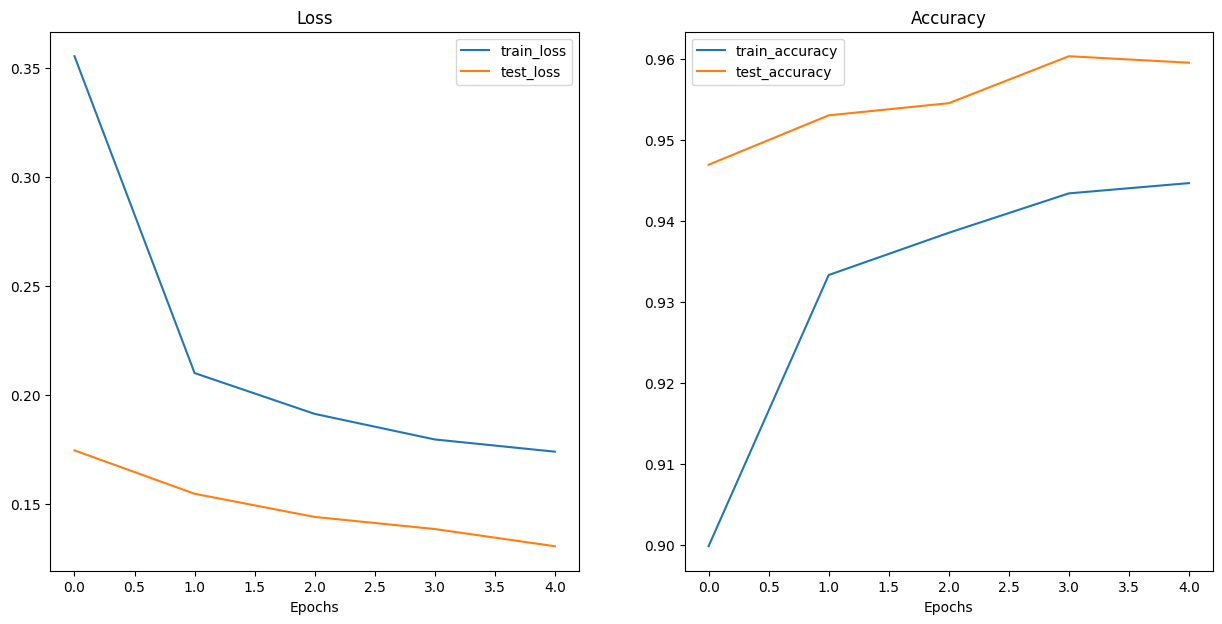

In [ ]:
from helper_functions import plot_loss_curves
plot_loss_curves(results = results_pretrained_model)